In [1]:
import os
import json
import glob
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [2]:
# Define dataset paths
DATASET_PATH = "100k"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")

In [3]:
# Define object detection classes in BDD dataset
CLASS_MAPPING = {
    "bus": 0,
    "traffic light": 1,
    "traffic sign": 2,
    "person": 3,
    "bike": 4,
    "truck": 5,
    "motor": 6,
    "car": 7,
    "train": 8,
    "rider": 9,
}

In [4]:
def parse_annotations(json_folder):
    """
    Parses annotation JSON files to extract bounding box data and metadata.

    Args:
        json_folder (str): Path to the folder containing JSON annotations.

    Returns:
        list: A list of dictionaries containing image name, object class, bbox details, occlusion status, and metadata.
    """
    data = []
    json_files = glob.glob(os.path.join(json_folder, "*.json"))

    for json_file in json_files:
        with open(json_file, "r") as f:
            annotation = json.load(f)

        for frame in annotation["frames"]:
            image_name = os.path.splitext(os.path.basename(json_file))[0] + ".jpg"
            for obj in frame["objects"]:
                if "box2d" in obj and obj["category"] in CLASS_MAPPING:
                    bbox = obj["box2d"]
                    data.append(
                        {
                            "image": image_name,
                            "class": obj["category"],
                            "x1": bbox["x1"],
                            "y1": bbox["y1"],
                            "x2": bbox["x2"],
                            "y2": bbox["y2"],
                            "occluded": obj["attributes"].get("occluded", False),
                            "truncated": obj["attributes"].get("truncated", False),
                            "weather": annotation["attributes"]["weather"],
                            "scene": annotation["attributes"]["scene"],
                            "timeofday": annotation["attributes"]["timeofday"],
                        }
                    )

    logging.info(f"Parsed {len(data)} bounding boxes from {len(json_files)} JSON files in {json_folder}.")
    return data


def analyze_class_distribution(data):
    """
    Analyzes the distribution of object classes in the dataset.
    """
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df["class"], order=df["class"].value_counts().index, palette="viridis", hue=df["class"])
    plt.xlabel("Count")
    plt.ylabel("Object Class")
    plt.title("Distribution of Object Classes in Dataset")
    plt.show()


def analyze_bbox_sizes(data):
    """
    Analyzes the size distribution of bounding boxes (width, height, aspect ratio).
    """
    df = pd.DataFrame(data)
    df["width"] = df["x2"] - df["x1"]
    df["height"] = df["y2"] - df["y1"]
    df["aspect_ratio"] = df["width"] / df["height"]

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df["width"], color="blue")
    plt.title("Bounding Box Width Distribution")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df["height"], color="red")
    plt.title("Bounding Box Height Distribution")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(df["aspect_ratio"], bins=30, kde=True, color="purple")
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.title("Bounding Box Aspect Ratio Distribution")
    plt.show()


def analyze_occlusion_truncation(data):
    """
    Analyzes occlusion and truncation frequency in object annotations.
    """
    df = pd.DataFrame(data)
    occluded_count = df["occluded"].sum()
    truncated_count = df["truncated"].sum()

    plt.figure(figsize=(8, 4))
    sns.barplot(x=["Occluded", "Truncated"], y=[occluded_count, truncated_count], palette="coolwarm", hue=["Occluded", "Truncated"], legend=False)
    plt.ylabel("Count")
    plt.title("Occlusion & Truncation Statistics")
    plt.show()


def analyze_metadata_distribution(data):
    """
    Analyzes weather, scene, and time of day distributions in dataset.
    """
    df = pd.DataFrame(data)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    sns.countplot(y=df["weather"], ax=axes[0], palette="Set2", hue=df["weather"], legend=False)
    axes[0].set_title("Weather Distribution")

    sns.countplot(y=df["scene"], ax=axes[1], palette="Set2", hue=df["scene"], legend=False)
    axes[1].set_title("Scene Distribution")

    sns.countplot(y=df["timeofday"], ax=axes[2], palette="Set2", hue=df["timeofday"], legend=False)
    axes[2].set_title("Time of Day Distribution")

    plt.tight_layout()
    plt.show()
    

def analyze_split_ratio(train_data, val_data):
    """
    Compares the class distributions in training and validation sets.
    """
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)

    plt.figure(figsize=(12, 6))
    sns.histplot(train_df["class"], color="blue", label="Train", alpha=0.6, kde=True)
    sns.histplot(val_df["class"], color="red", label="Validation", alpha=0.6, kde=True)
    plt.xlabel("Object Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution in Train vs Validation Set")
    plt.legend()
    plt.show()


def main():
    """
    Main function to run data analysis on the BDD dataset.
    """
    logging.info("Starting data analysis...")

    # Parse annotations
    train_data = parse_annotations(TRAIN_PATH)
    val_data = parse_annotations(VAL_PATH)

    # Perform analyses
    analyze_class_distribution(train_data)
    analyze_bbox_sizes(train_data)
    analyze_occlusion_truncation(train_data)
    analyze_metadata_distribution(train_data)
    analyze_split_ratio(train_data, val_data)

    logging.info("Data analysis complete!")  

2025-02-14 04:14:56,363 - INFO - Starting data analysis...
2025-02-14 04:15:10,057 - INFO - Parsed 1288405 bounding boxes from 70000 JSON files in /home/akshay/Documents/TANU/Bosch/100k/train.
2025-02-14 04:15:12,039 - INFO - Parsed 185578 bounding boxes from 10000 JSON files in /home/akshay/Documents/TANU/Bosch/100k/val.


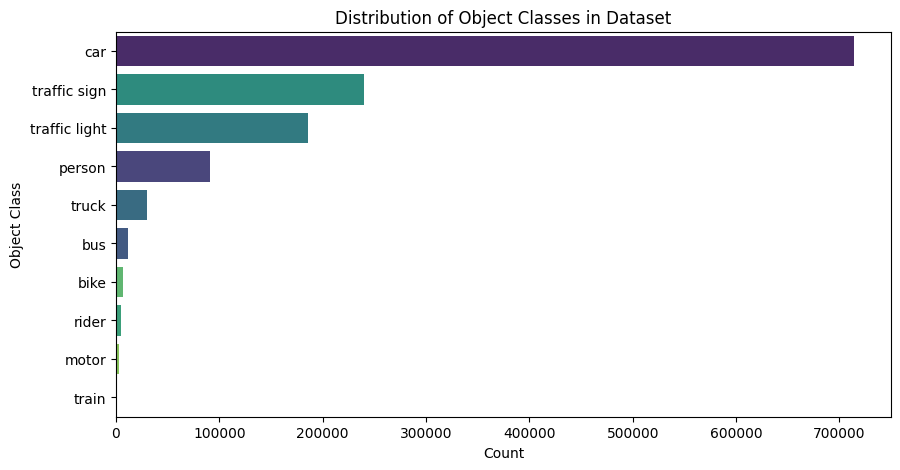

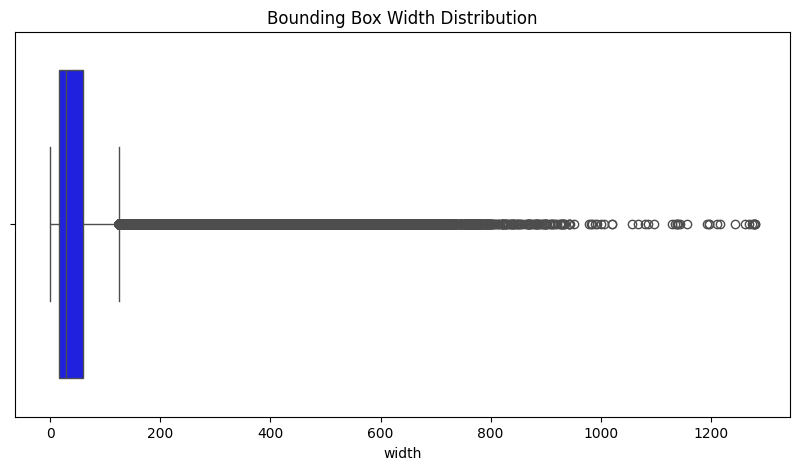

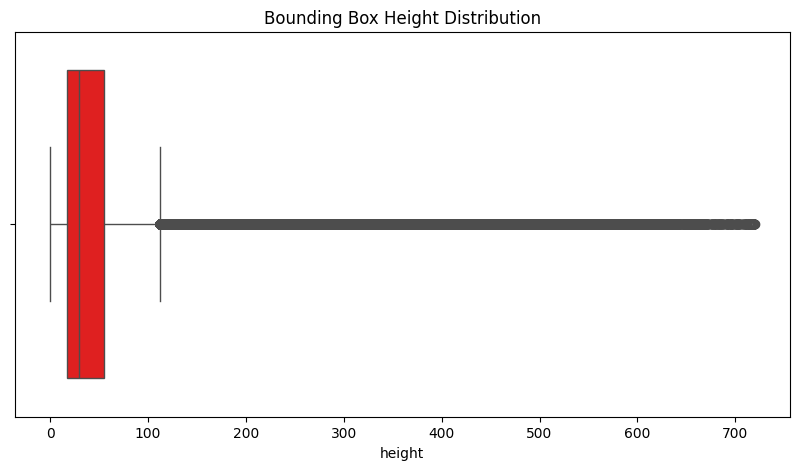

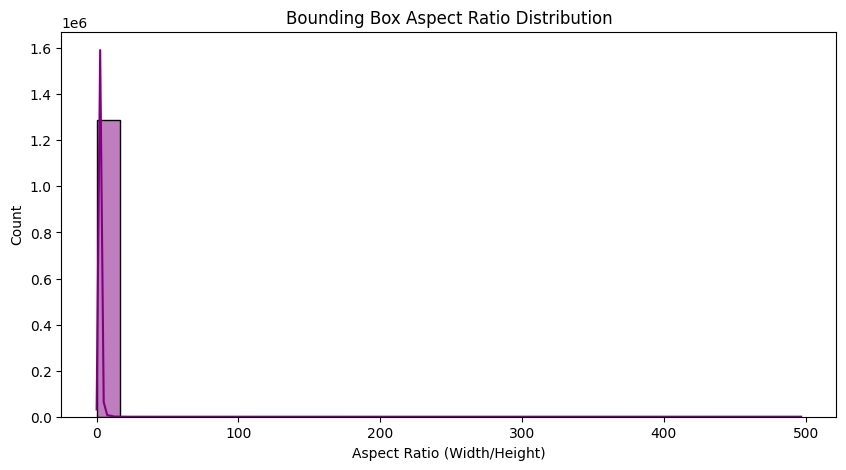

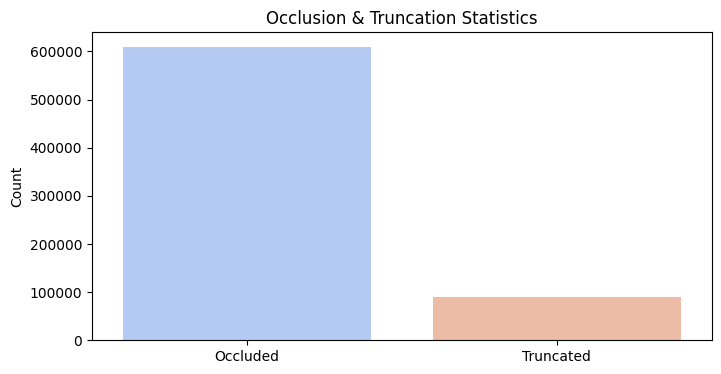

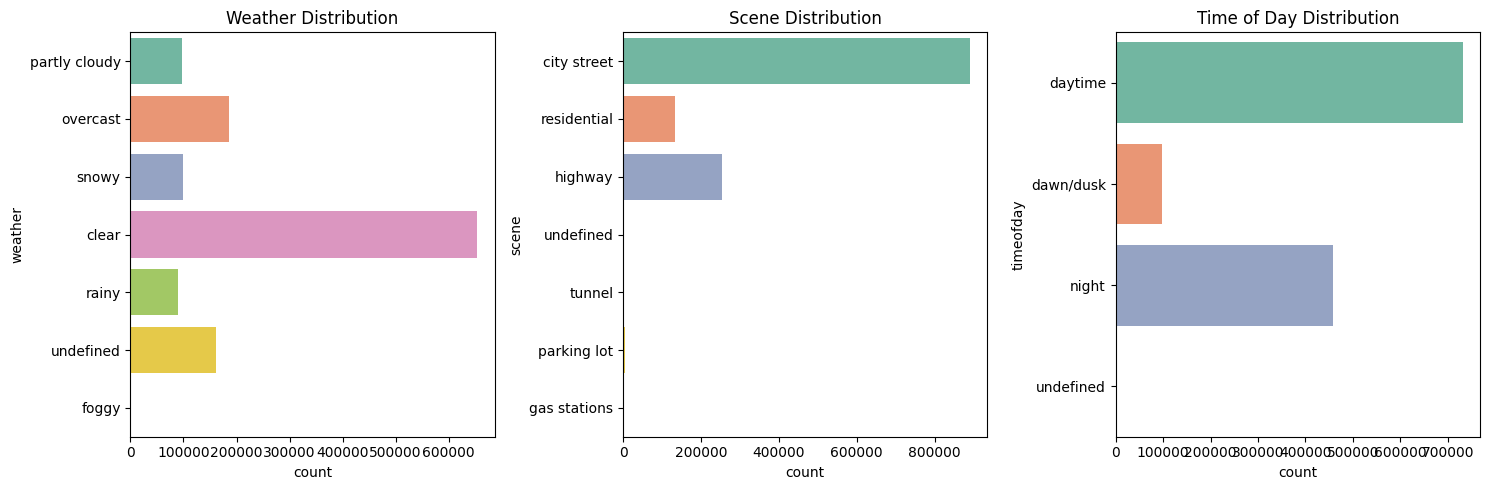

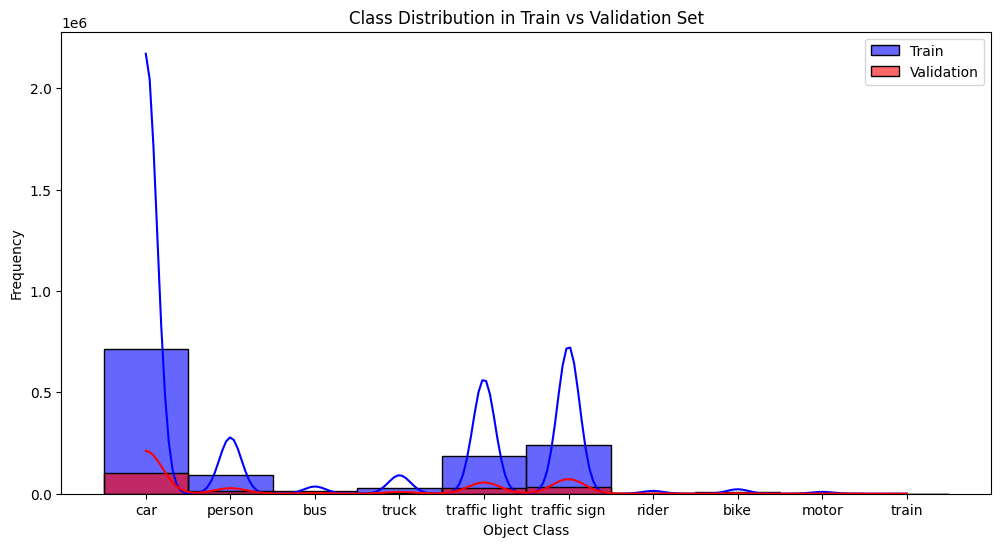

2025-02-14 04:15:37,488 - INFO - Data analysis complete!


In [5]:
main()